# 䁖一眼MNIST数据

In [1]:
import os
from sklearn.datasets import fetch_openml
data_path = os.path.join(os.getcwd(),'scikit_learn_data')
mnist = fetch_openml('mnist_784',version=1,data_home=data_path)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X = mnist["data"]
y = mnist["target"]
## X是一个矩阵，70000×784的，70000表示70000张图片，每张图片784个特征，这个特征数是 28×28 像素然后拼成一列来的
## y就是一个向量，70000个标签表示这张图片上的数字是多少
X = X.to_numpy()

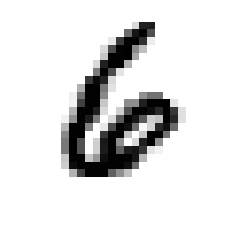

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# 取一张图片看看
some_digit = X[13]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap = mpl.cm.binary,interpolation="nearest") # 采取最近邻插值
plt.axis("off")
plt.show()

In [10]:
X_train,y_train,X_test,y_test = X[:60000],y[:60000],X[60000:],y[60000:]
y = y.astype(np.uint8) # 将所有字符串的标签转化为数字

# 做一个Binary的分类器(二分类器)

In [11]:
# 这里我们做一个能识别是否是6的识别器

In [12]:
# 注意这里需要用binary的标签去训练
y_train_6 = (y_train == 6)
y_test_6 = (y_test == 6)
# 选择用sklearn的随机梯度下降分类器(SGD)来进行训练
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_6) # 只用关于6的binary的标签来训练仅能识别6的分类器
sgd_clf.predict([some_digit]) # []将输入参数变化为2维的

array([ True])

In [ ]:
# 我们接着想要评估一下这个分类器的表现能力，在此之前需要看看如何衡量表现能力

# Performance Measures

#### 使用Accuracy来作为Performance Measures

In [ ]:
#### 这里的Accuracy一般从交叉验证中算出来
#### 先手写实现一波交叉验证
#################################### Manual Cross Validation ###########################################
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# 先对训练集数据进行分层然后再划分Folds
# 分层使得划分出的Folds中每个类别的待识别样本的比例基本一致
skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle=True) # 划分成三家 train/test 集

for train_index, test_index in skfolds.split(X_train,y_train_6): # 用上面定义的模式去分 X_train集和y_train_6集
    clone_clf = clone(sgd_clf)
    X_train_fold = X_train[train_index]
    y_train_6_fold = y_train_6[train_index] ## 这两个用于训练
    X_test_fold = X_train[test_index]  ## 这个用于预测
    y_test_6_fold = y_train_6[test_index]  ## 这个用于对比预测结果
    
    clone_clf.fit(X_train_fold,y_train_6_fold)
    y_predictions = clone_clf.predict(X_test_fold)
    n_accurate = sum(y_test_6_fold == y_predictions)
    print(n_accurate/len(y_predictions))
    
########################################################################################################

In [13]:
## 以上都是手动的，下面是sklearn提供给我们的
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_6,cv=3,scoring="accuracy") # 声明采用accuracy的方式来计算测试/验证的分数

array([0.9829 , 0.98025, 0.9804 ])

In [ ]:
## 这个准确率就离谱吧，让我们来看看一个摆烂分类器(判断不是6的分类器)
from sklearn.base import BaseEstimator
class BaiLanClassifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X,y=None):
        return np.zeros((len(X),1),dtype=bool)
bailan_clf = BaiLanClassifier()
cross_val_score(bailan_clf,X_train,y_train_6,scoring="accuracy")

In [ ]:
## 就这摆烂的都能上90%的准确率
## 因为整个训练集中只有差不多10%的6，而有差不多90%的不是6，因此就算判断是6的准确率不高，另一方面判断不是6的准确率那也会相当高的
## 这么看来，准确率虽然在衡量判断一些类别时的结果令人激动，但是在衡量判断另一些类别时的结果却有点离谱
## 所以准确率并不是一种很好的用来衡量分类效果的指标，那下面看看混淆矩阵怎么样(Confusion Matrix)

#### Confusion Matrix(混淆矩阵)

In [14]:
## 混淆矩阵的思想就是 统计A类实例被归类为B类的次数
## 混淆矩阵的出现会牵涉到后面 Precision和 Recall概念的出现
## 一个混淆矩阵需要多组预测的结果
from sklearn.model_selection import cross_val_predict
# cross_val_predict 也会进行交叉验证的分fold的操作，但是它在分出fold，决定哪些是train_fold，哪些是test_fold后
# 会用train_fold训练模型，用test_fold喂给模型得出predictions,而不会进一步地计算分数，所以下面的参数中没有scoring的参数
y_trained_pred = cross_val_predict(sgd_clf,X_train,y_train_6,cv = 3)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_6,y_trained_pred)

array([[53562,   520],
       [  609,  5309]], dtype=int64)

In [ ]:
# 这个就是混淆矩阵了
# 对于这个二分类问题，第一行是Negative(非6)类，第二行是Positive(6)类，是Actual的
# 第一列是预测的Negative，第二列是预测的Positive
# 第一个数字表示本来是Neg的预测还是为Neg，是True Negative(TN)
# 第二个数字表示本来是Neg的预测却是为Pos, 是False Positive(FP)
# 第三个数字表示本来是Pos的预测却是为Neg, 是False Negative(FN)
# 第四个数字表示本来是Pos的预测还是为Pos, 是True Positive(TP)
## 接下来介绍Precision和Recall的计算方法和具体含义

#### Precision & Recall

In [ ]:
# Precision = TP/(TP+FP) 表示预测结果为Positive的样本中预测对了的占多大比例
# Recall = TP/(TP+FN) 表示在所有预测的Positive样本中，预测对了的占多大比例

In [15]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_6,y_trained_pred)

0.9107908732201063

In [17]:
recall_score(y_train_6,y_trained_pred)

0.8970936127069956

In [20]:
## precision的 91%说明当这个分类器声称检测的图片是6时，只有91%的准确度
## recall的89%说明这个分类器只检测出了89.7%的6的图片
## 另外有一种结合了Precision和Recall的指标，称为 F1 score
## F1 score是Precision和Recall的调和平均 F1 = 2/(1/precision+1/recall)
from sklearn.metrics import f1_score
f1_score(y_train_6,y_trained_pred)

0.9038903549842513

In [22]:
### 并不是Precision和Recall都越高越好，一方面是因为Precision越高，Recall反而越低
### 另一方面 和我们关心的问题也有关系，比如你在做一个视频网站的青少年模式
### 那你肯定想对于不好的视频宁可错抓也不能漏抓，因此即使对于正能量的视频我们也应该十分谨慎，这样就需要低的Recall和高的Precision

### Precision越高，Recall反而越低或者反之亦反的现象称为 Precision和Recall的Tradeoff
### 这种tradeoff和分类器中的阈值(threshold)设置有关，分类器先计算出每一个样本的score然后根据阈值给它标签
### decision_function直接给出某个样本的分数
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([366.75411508])

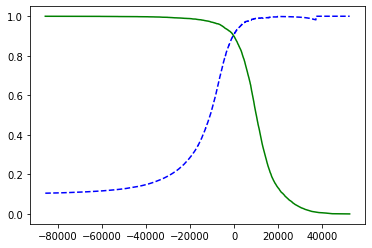

In [17]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf,X_train,y_train_6,cv = 3,method="decision_function") ## 使用method字段的 decision_function 值给出所有样本的分数
## 一般来说 一个score一个threshold可以确定一组precision和recall
## 这里使用precision_recall_curve计算出在所有可能的threshold下的所有precision和recall组，threshold和precision,recall组是一一对应的
precisions,recalls,thresholds = precision_recall_curve(y_train_6,y_scores)
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
    [...] # highlight the threshold, add the legend, axis label and grid
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

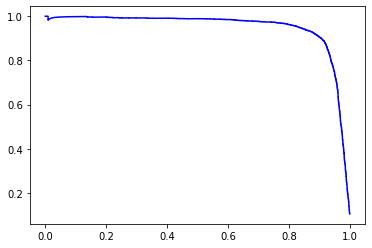

In [18]:
## 直接画一波 Precision Aginst Recall 的图
plt.plot(recalls,precisions,'b-')

In [29]:
## 假如现在的需求是要找到使得precision至少为90%的最小threshhold
precision_90_threshold = thresholds[np.argmax(precisions>=0.9)] # np.argmax()返回参数中最大值出现的第一个索引
## 然后我们就可以用这个threshold不用采取predict的方式也可以进行预测了
y_train_pred_90 = (y_scores>=precision_90_threshold)

precision_score(y_train_6,y_train_pred_90)

0.9000670690811536

In [30]:
recall_score(y_train_6,y_train_pred_90)

0.9070631970260223

#### ROC curve (受试者工作特征曲线)

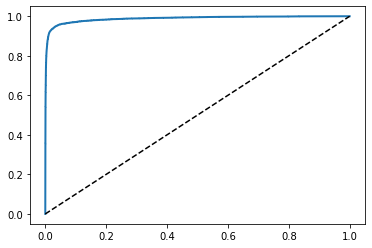

In [19]:
# ROC curve 描述的是 True Positive Rate(TPR) aginst False Positive Rate(FPR) 的曲线
# TPR也就是Recall(TP/(TP+FN))表示的是所有positive样本中被正确识别为positive的样本的比率
# FPR表示所有negative样本中被错误识别为positive的样本比率，它等于1-(TN/(TN+FP) TNR,specificity)
# 画ROC的图需要先计算TPR 和FPR
from sklearn.metrics import roc_curve
# 这里的模式都是先从 cross_val_predict 算出各个样本的分数，然后再根据分数和标签通过xxxx_curve算出 fpr,tpr,pr,recall啥的
fpr,tpr,thresholds = roc_curve(y_train_6,y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 对角线，画法和matlab的line函数差不多
    [...] # Add axis labels and grid
plot_roc_curve(fpr,tpr)
plt.show()

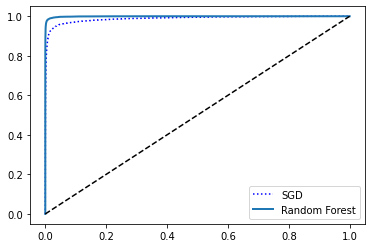

In [22]:
# 可以看到随着tpr的增大，fpr也在增大
# 那一条对角线表示一个随机classifier的ROC曲线
# 对角线上越往左上分类器的效果越好，如果一个分类器的ROC线条出现在对角线下方，那么表示这个分类器比一个随机分类器都还拉胯

# 对于是选用ROC曲线还是选用PR曲线，我们一般的经验是，如果positive的总样本少或者我们更关心假阳性那么就选用PR曲线；反之则选择ROC曲线

# 对于上面的这个SGD的分类器从ROC曲线看过去还是可以，但是上面的PR曲线表明他还有很大的进步空间

# 下面用 RandomForestClassifier 来康康
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)
# 由于RandomForestClassifier自身模型的原因，它没有算score的方法，但是有计算probability的方法
forest_prob = cross_val_predict(forest_clf,X_train,y_train_6,cv = 3,method="predict_proba")
# 计算出的forest_prob是一个矩阵，行表示每个样本，列表示每个类，每个元素表示这个样本属于这个类的概率
# 这里由于是二分类问题，所以只有两列，同时我们采用每个样本的positive类的概率来表示这个样本的分数
forest_prob_score = forest_prob[:,1]
# 然后就可以计算fpr,tpr了
fprs,tprs,thresholds = roc_curve(y_train_6,forest_prob_score)
plt.plot(fpr,tpr,'b:',label="SGD")
plot_roc_curve(fprs,tprs,'Random Forest')
plt.legend(loc="lower right")
plt.show()

In [23]:
# 另外，还有一种方式来对分类器进行比较，即使用ROC曲线下方的面积(AUC)
from sklearn.metrics import roc_auc_score
# SGD的auc
roc_auc_score(y_train_6,y_scores)

0.9878749264865954

In [25]:
# RandomFroest的auc
roc_auc_score(y_train_6,forest_prob_score)

0.9991551090374211

In [ ]:
#### 以上就是构建二分类器的全部内容了，考虑一下下面的问题
####### 1. 如何训练一个二分类器
####### 2. 如何选择一个(或多个组合的)合适的performance度量
####### 3. 如何通过交叉验证来评估这个二分类器   这样的评估与上面选择的度量直接相关
####### 4. 根据实际需要选择合适的 precision/recall tradeoff (实际上就是选择合适的thresholds)
####### 5. 如何使用ROC曲线或者(ROC AUC)来比较不同的二分类模型